# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [229]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [230]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [231]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [294]:
def pk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
  return np.mean([predicted[:k][i] in relevant for i in range(k)])

def apk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):

  return np.sum([(predicted[:k][i] in relevant) * pk(relevant, predicted, i+1) for i in range(k)]) / min(k, len(relevant))

def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):

  return np.mean([apk(r, p, k) for r, p in zip(relevant, predicted)])


In [295]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [296]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [297]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [298]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [299]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [300]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [301]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [302]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [303]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [304]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):

        test_preds = []

        for uid in self.ratings['userId'].unique():
            recs = self.recommend(uid)
            test_preds.append(recs)

        return self.remove_train_items(test_preds, k)

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [305]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:

    return (ratings @ user_vector) / ((np.sqrt(np.sum(ratings, axis = 1))) * np.sqrt(np.sum(user_vector)))


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:

    return (ratings @ user_vector) / np.sum(ratings + user_vector > 0, axis = 1)

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [306]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        # assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """

        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):

        s = self.similarity(self.R[uid])

        N = np.setdiff1d(np.argwhere(s > self.alpha)[:, 0], [0], assume_unique = True)

        return np.argsort((s[N] @ self.R[N]) / np.sum(s[N]))[::-1]

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [310]:
from collections import defaultdict

scores = defaultdict(list)

for func in [('Pearson', pearson), ('Jaccard', jaccard), ('Random', pearson)]:

  model = User2User(train_ratings, similarity_func = func[1])

  recom = model.get_test_recommendations(50) if func[0] != 'Random' \
          else np.asarray([tracks_info.sample(50)['id'] for i in range(model.n_users)])

  for k in range(1, 51):

    scores[func[0]].append(mapk(test_relevant, recom, k))



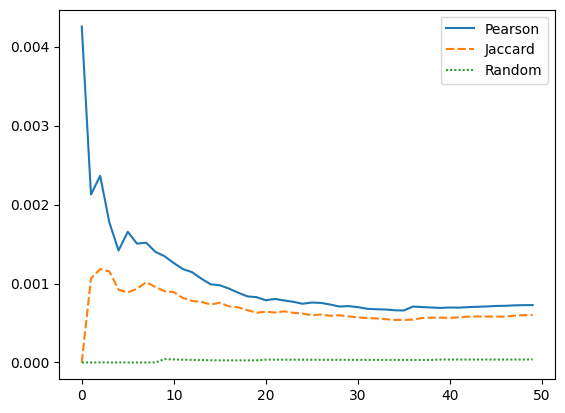

In [311]:
sns.lineplot(data = pd.DataFrame(scores));

> <div style = 'color:red'>Вывод:</div>
>
> #### Как и было ожидаемо, худший показатель у случайных рекоммендаций. С большим отрывом вначале по метрике MAP@k лидирует использование корреляции Пирсона, но в дальнейшем качества методов, в которых используются корреляции Пирсона и мера Жакара, выравниваются

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [312]:
class User2UserFasten(User2User):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings, similarity_func)

        self.R = scs.csr_matrix(self.R)


In [313]:
import time

start = time.time()
p = User2User(train_ratings, similarity_func = pearson)
p_r = p.get_test_recommendations(50)
print(f'Pearson - before: {time.time() - start: .2f} sec')

start = time.time()
j = User2User(train_ratings, similarity_func = jaccard)
j_r = j.get_test_recommendations(50)
print(f'Jaccard - before: {time.time() - start: .2f} sec')


Pearson - before:  12.01 sec
Jaccard - before:  29.20 sec


In [314]:
def pearsonSparsed(ratings: scs.csr_matrix, user_vector: scs.csr_matrix) -> np.array:

    return (ratings @ user_vector.T / np.sqrt(ratings.multiply(ratings).sum(axis=1)) * \
            np.sqrt(user_vector.multiply(user_vector).sum())).toarray().flatten()


def jaccardSparsed(ratings: scs.csr_matrix, user_vector: scs.csr_matrix):
    return  ratings.multiply(user_vector).sum(axis=1).A1 / (ratings.sum(axis=1).A1 + user_vector.sum(axis=1).A1 -
                                                            ratings.multiply(user_vector).sum(axis=1).A1)

start = time.time()
p = User2UserFasten(train_ratings, similarity_func = pearsonSparsed)
p_r = p.get_test_recommendations(50)
print(f'Pearson - after: {time.time() - start: .2f} sec')

start = time.time()
j = User2UserFasten(train_ratings, similarity_func = jaccardSparsed)
j_r = j.get_test_recommendations(50)
print(f'Jaccard - after: {time.time() - start: .2f} sec')

Pearson - after:  2.74 sec
Jaccard - after:  2.14 sec


Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [315]:
user_id = np.random.randint(0, model.n_users)

In [316]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
177,Paper Planes,['M.I.A.']
269,Scars,['Papa Roach']
344,Somebody Told Me,['The Killers']
374,The Adventure,['Angels & Airwaves']
419,The Real Slim Shady,['Eminem']
421,Lose Yourself,['Eminem']
422,Stan,"['Eminem', 'Dido']"
427,My Name Is,['Eminem']
556,All These Things That I've Done,['The Killers']
557,Personal Jesus,['Marilyn Manson']


In [317]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
2814,Numb,['Linkin Park']
805,Zombie,['The Cranberries']
7533,Highway to Hell,['AC/DC']
2555,Californication,['Red Hot Chili Peppers']
1019,It's My Life,['Bon Jovi']
3106,Can't Stop,['Red Hot Chili Peppers']
26784,"Муж, с которым ты живёшь",['Ирина Аллегрова']
1131,The Unforgiven,['Metallica']
164,My Favourite Game,['The Cardigans']
11493,"Baby, Its Cold Outside",['Rosemary Clooney']


In [318]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
37322,Извозчик,['Александр Розенбаум']
37369,За край,"['Truwer', '104']"
37462,The Great Warrior,['Guido Negraszus']
37724,Однажды ты,['Слава']
38604,Resurection (Robot's Outro),['PPK']
38713,Песня,['СЕВЕР.17']
39029,Heavy,['Linkin Park']
39185,INTERNAL,['FLESH']
39189,Illuminate the Trail,['Textures']
39809,Diddy Bop,"['Jacob Banks', 'Louis The Child']"


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:**

$$ p_{uk} := p_{uk} - \eta (2(\hat r_{ui} - r_{ui})q_{ik} + 2 \lambda p_{uk}) $$

$$ q_{ik} := q_{ik} - \eta (2(\hat r_{ui} - r_{ui})p_{uk} + 2 \lambda q_{ik}) $$

\\
**ALS:**

$$ p_u = (\sum_{i \in I}q_i q_i^T + \lambda I)^{-1} \sum_{i \in I} r_{ui} q_i $$

$$ q_i = (\sum_{u \in U}p_u p_u^T + \lambda I)^{-1} \sum_{u \in U} r_{ui} p_u $$

**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [348]:
from joblib import Parallel, delayed, cpu_count

class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb_sgd = 150
        self.lamb_als = 2.75

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':

                u, i = np.where(self.R == 1)
                u, i = np.random.choice(u), np.random.choice(i)

                p, q = self.P[u], self.Q[i]

                self.P[u] = p - 2 * self.lr * ((p @ q - self.R[u, i]) * q + self.lamb_sgd * q)
                self.Q[i] = q - 2 * self.lr * ((p @ q - self.R[u, i]) * p + self.lamb_sgd * q)

            elif self.mode == 'als':


                p_upd = lambda u, i: np.linalg.inv(self.Q[i].T @ self.Q[i] + self.lamb_als * np.eye(self.dim)) \
                        @ (self.Q[i].T @ self.R[u, i].T)

                q_upd = lambda u, i: np.linalg.inv(self.P[u].T @ self.P[u] + self.lamb_als * np.eye(self.dim)) \
                        @ (self.P[u].T @ self.R[u, i])

                usrs = Parallel(n_jobs = cpu_count())(([delayed(p_upd)(u, np.where(self.R[u] == 1)[0]) for u in range(self.n_users)]))

                for user in range(self.n_users):
                  self.P[user] = usrs[user]

                itms = Parallel(n_jobs = cpu_count())(([delayed(q_upd)(np.where(self.R[:, q] == 1)[0], q) for q in range(self.n_items)]))

                for item in range(self.n_items):
                  self.Q[item] = itms[item]


    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [352]:
model = HiddenVars(train_ratings, mode='als')
model.fit()

  0%|          | 0/5 [00:00<?, ?it/s]

In [353]:
model2 = HiddenVars(train_ratings, mode='sgd')
model2.fit()

  0%|          | 0/5 [00:00<?, ?it/s]

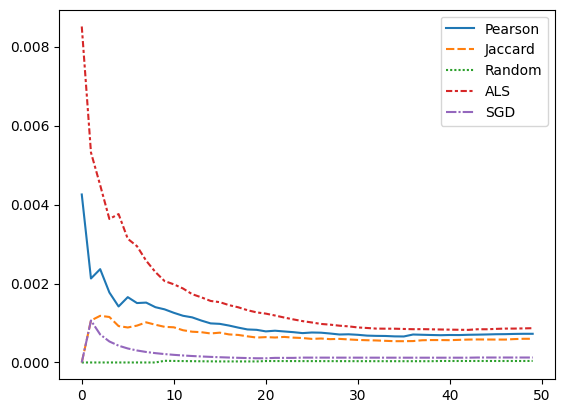

In [354]:
scores_new = scores.copy()

pred = model.get_test_recommendations(50)
pred2 = model2.get_test_recommendations(50)

for k in range(1, 51):

    scores_new['ALS'].append(mapk(test_relevant, pred, k))
    scores_new['SGD'].append(mapk(test_relevant, pred2, k))


sns.lineplot(data = pd.DataFrame(scores_new));

> ### <div style='color:red'> Вывод:</div>
>
> #### Значение показателя MAP@k получилось больше, чем в подходе User2User: на графике для 4 позиции для обеих функций схожести значения MAP получились значительно меньше, чем для ALS ⇒ получилось улучшение
>
> #### Также использование SGD помогло обойти по качеству случайные рекоммендации (ура) и на небольшом горизонте был тот же результат, что и при использовани меры Жакара

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [285]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [286]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
24284,Как на войне,['Агата Кристи'],0.901399
5517,Варвара,['Би-2'],0.866217
5872,Я свободен,['Кипелов'],0.860448
17328,Я хочу быть с тобой,['Nautilus Pompilius'],0.859074
5521,Полковнику никто не пишет,['Би-2'],0.848410
6053,Brother Louie,['Modern Talking'],0.848321
15242,Батарейка,['Жуки'],0.842111
20259,Беспечный ангел,['Ария'],0.841843
12386,Молитва,['Би-2'],0.840078
